# Lesson 8 Simple Artificial Neural Network

Setup

~~~
conda install seaborn numpy sklearn keras tensorflow
~~~

Adapted from https://github.com/fastforwardlabs/keras-hello-world


In [1]:
import seaborn as sns
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegressionCV

from keras.models import Sequential
from keras.layers.core import Dense, Activation
from keras.utils import np_utils

Using TensorFlow backend.


## Loading Iris data

We load it from seaborn so that we can load this notebook in Google Colaboratory easily

In [2]:
iris = sns.load_dataset("iris")
iris.head()

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


## Munge and split the data for training and testing

First we need to pull the raw data out of the `iris` dataframe. We'll hold the petal and sepal data in an array `X` and the species labels in a corresponding array `y`.

In [3]:
X = iris.values[:, :4]
y = iris.values[:, 4]

As is standard in supervised machine learning, we'll train with some of the data, and measure the performance of our model with the remainder. This is simple to do by hand, but is also built into scikit-learn as the `train_test_split()` function.

In [4]:
train_X, test_X, train_y, test_y = train_test_split(X, y, train_size=0.5, test_size=0.5, random_state=0)

# Train a scikit-learn classifier

We'll train a logisitic regression classifier. Doing this, with built-in hyper-paramter cross validation, is one line in scikit-learn. Like all scikit-learn `Estimator` objects, a `LogisticRegressionCV` classifier has a `.fit()` method that takes care of the gory numerical details of learning model parameters that best fit the training data. So that method is all we need to do:

In [5]:
lr = LogisticRegressionCV(cv=3, multi_class='ovr')
lr.fit(train_X, train_y)

LogisticRegressionCV(Cs=10, class_weight=None, cv=3, dual=False,
                     fit_intercept=True, intercept_scaling=1.0, l1_ratios=None,
                     max_iter=100, multi_class='ovr', n_jobs=None, penalty='l2',
                     random_state=None, refit=True, scoring=None,
                     solver='lbfgs', tol=0.0001, verbose=0)

# Assess the classifier using accuracy

Now we can measure the fraction of of the test set the trained classifer classifies correctly (i.e., accuracy).

In [6]:
print("Accuracy = {:.2f}".format(lr.score(test_X, test_y)))

Accuracy = 0.83


# Now do something very similar with Keras

In [7]:
def one_hot_encode_object_array(arr):
    '''One hot encode a numpy array of objects (e.g. strings)'''
    uniques, ids = np.unique(arr, return_inverse=True)
    return np_utils.to_categorical(ids, len(uniques))

train_y_ohe = one_hot_encode_object_array(train_y)
test_y_ohe = one_hot_encode_object_array(test_y)

In [8]:
print(train_y)
print(train_y_ohe)

['setosa' 'virginica' 'versicolor' 'setosa' 'versicolor' 'virginica'
 'versicolor' 'setosa' 'virginica' 'virginica' 'virginica' 'virginica'
 'setosa' 'setosa' 'virginica' 'virginica' 'setosa' 'virginica' 'setosa'
 'virginica' 'virginica' 'setosa' 'setosa' 'virginica' 'setosa' 'setosa'
 'setosa' 'versicolor' 'virginica' 'virginica' 'setosa' 'setosa' 'setosa'
 'versicolor' 'versicolor' 'setosa' 'setosa' 'versicolor' 'setosa'
 'virginica' 'versicolor' 'virginica' 'versicolor' 'setosa' 'virginica'
 'setosa' 'virginica' 'setosa' 'setosa' 'virginica' 'setosa' 'virginica'
 'versicolor' 'versicolor' 'versicolor' 'virginica' 'virginica'
 'versicolor' 'versicolor' 'setosa' 'versicolor' 'virginica' 'virginica'
 'setosa' 'versicolor' 'versicolor' 'versicolor' 'versicolor' 'setosa'
 'setosa' 'setosa' 'virginica' 'versicolor' 'virginica' 'setosa']
[[1. 0. 0.]
 [0. 0. 1.]
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [1. 0. 0.

# Build the neural network model

Aside from the data munging required in this particular case, the most signifcant and important difference with working with Keras is that you have to specify the structure of the model before you can instantiate and use it.

In scikit-learn, the models are off-the-shelf. But Keras is a neural network library. As such, while the number of features/classes in your data provide constraints, you can determine all the other aspects of model structure: number of layers, size of layers, the nature of the connections between the layers, etc. (And if that didn't make sense, Keras is a great way to experiment with it!)

The upshot of this freedom is that instaniating a minimal classifier involves a bit more work than the one line required by scikit-learn.

In our case, we'll build an extremely simple network. Two of the choices are made for us by the data. We have four features and three classes, so the input layer must have four units, and the output layer must have three units. We only have to define the hidden layers. We're only going to have one hidden layer for this project, and we'll give it 16 units. From the point of view of a GPU, 16 is a round number! You'll see a lot of powers of 2 when you work with neural networks.

We're going to define our model in the most common way: as a sequential stack of layers. The alternative is as a computational graph, but we're going to stick to `Sequential()` here.

In [9]:
model = Sequential()

The next two lines define the size input layer (input_shape=(4,), and the size and activation function of the hidden layer

In [10]:
model.add(Dense(16, input_shape=(4,)))
model.add(Activation('sigmoid'))

Instructions for updating:
Colocations handled automatically by placer.


... and the next line defines the size and activation function of the ouput layer.

In [11]:
model.add(Dense(3))
model.add(Activation('softmax'))

Finally we specify the optimization strategy and the loss function to optimize. We also instruct the model to calculate accuracy as it works.

In [12]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=["accuracy"])

In [13]:
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 16)                80        
_________________________________________________________________
activation_1 (Activation)    (None, 16)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 51        
_________________________________________________________________
activation_2 (Activation)    (None, 3)                 0         
Total params: 131
Trainable params: 131
Non-trainable params: 0
_________________________________________________________________
None


Can you figure out how the param# get calculated?


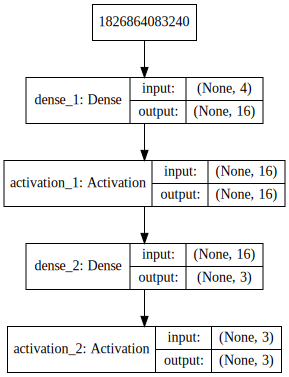

In [14]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))

# Use the neural network classifier

Now we've defined the structure model and compiled it, we have an object whose API is almost identical to a classifier in scikit-learn. In particular, it has `.fit()` and `.predict()` methods. Let's `fit`.

Training neural networks often involves the concept of "minibatching", which means showing the network a subset of the data, adjusting the weights, and then showing it another subset of the data. When the network has seen all the data once, that's called an "epoch". Tuning the minibatch/epoch strategy is a somewhat problem-specific issue, but in this case we'll just use a minibatch of 1. That makes it effectively good old stochastic gradient descent, i.e. the data is shown to the network one flower at a time, and the weights adjusted immediately.

Feel free to rerun this cell with `verbose=0` removed. Note that if you want to experiment with the minibatch/epoch strategy you should rerun the previous cell that ran `model.compile()` to reinitialize the model weights.

In [15]:
model.fit(train_X, train_y_ohe, epochs=100, batch_size=1, verbose=1);

Instructions for updating:
Use tf.cast instead.
Epoch 1/100
75/75 [==============================] - 1s 13ms/step - loss: 1.4170 - acc: 0.2667
Epoch 2/100
75/75 [==============================] - 0s 2ms/step - loss: 1.1487 - acc: 0.2800
Epoch 3/100
75/75 [==============================] - 0s 2ms/step - loss: 1.0578 - acc: 0.6400
Epoch 4/100
75/75 [==============================] - 0s 2ms/step - loss: 1.0011 - acc: 0.7333
Epoch 5/100
75/75 [==============================] - 0s 1ms/step - loss: 0.9543 - acc: 0.7333
Epoch 6/100
75/75 [==============================] - 0s 1ms/step - loss: 0.9127 - acc: 0.7333
Epoch 7/100
75/75 [==============================] - 0s 1ms/step - loss: 0.8722 - acc: 0.7333
Epoch 8/100
75/75 [==============================] - 0s 1ms/step - loss: 0.8348 - acc: 0.7333
Epoch 9/100
75/75 [==============================] - 0s 1ms/step - loss: 0.8022 - acc: 0.7333
Epoch 10/100
75/75 [==============================] - 0s 1ms/step - loss: 0.7598 - acc: 0.7333
Epoch 11/1

75/75 [==============================] - 0s 1ms/step - loss: 0.1455 - acc: 0.9867
Epoch 85/100
75/75 [==============================] - 0s 1ms/step - loss: 0.1419 - acc: 0.9600
Epoch 86/100
75/75 [==============================] - 0s 1ms/step - loss: 0.1406 - acc: 0.9867
Epoch 87/100
75/75 [==============================] - 0s 1ms/step - loss: 0.1366 - acc: 0.9733
Epoch 88/100
75/75 [==============================] - 0s 1ms/step - loss: 0.1403 - acc: 0.9600
Epoch 89/100
75/75 [==============================] - 0s 1ms/step - loss: 0.1355 - acc: 0.9733
Epoch 90/100
75/75 [==============================] - 0s 1ms/step - loss: 0.1324 - acc: 0.9600
Epoch 91/100
75/75 [==============================] - 0s 1ms/step - loss: 0.1314 - acc: 0.9867
Epoch 92/100
75/75 [==============================] - 0s 2ms/step - loss: 0.1309 - acc: 0.9733
Epoch 93/100
75/75 [==============================] - 0s 2ms/step - loss: 0.1254 - acc: 0.9733
Epoch 94/100
75/75 [==============================] - 0s 2ms/st

For basic use, the only syntactic API difference between a compiled keras model and a scikit-learn classifier is that Keras's equivalent of the scikit-learn `.score()` method is called `.evaluate()`. 

`evaluate()` returns the loss function and any other metrics we asked for when we compiled the model. In our case, we asked for `accuracy`, which we can compare to the accuracy we got from the `.score()` method of our scikit-learn `LogisticRegressionCV` classifier.

In [16]:
loss, accuracy = model.evaluate(test_X, test_y_ohe, verbose=0)
print("Accuracy = {:.2f}".format(accuracy))

Accuracy = 0.97


As you can see, the test accuracy of the neural network model is better than that of the simple logistic regression classifier.

This is reassuring but not surprising. Even our very simple neural network has the flexibility to learn much more complicated classification surfaces than logisitic regression, so of course it does better than logisitic regression.

And it does hint at one of the dangers of neural networks: overfitting. We've been careful here to hold out a test set and measure performance with that, but it's a small set, and 99% accuracy seems awfully high to me, so I wouldn't be surprised if there was some overfitting going on. You could work on that by adding dropout (which is built in to Keras). That's the neural network equivalent of the regularization our LogisticRegression classifier uses.

But we'll stop here, because a neural network model is overkill for this problem, and worrying about accuracy is not the point of what I've shown you. The point is that using a batteries-included, high-level library like Keras means that we need to write only a little bit more code to build, train, and apply a neural network model than a traditional model.

# What next?

We built an extremely simple feed-forward network model. To experiment more, load the [MNIST database of handwritten digits](http://keras.io/datasets/) and see if you can beat a standard scikit-learn classifier. Unlike the Iris dataset, this is a situation where the power and relative complexity of neural networks is justified. Try it yourself first, but if you get stuck, take a look at [this notebook](https://github.com/wxs/keras-mnist-tutorial/blob/master/MNIST%20in%20Keras.ipynb).

Technical and engineering tutorials for your favourite language or library are easy to find, but if you're interested in some of the more conceptual and mathematical background, take a look at:
 - Michael Nielsen's online textbook "[Neural Networks and Deep Learning](http://neuralnetworksanddeeplearning.com/)" (especially chapters 1, 2 and 3)
 - Weeks 4 and 5 of Andrew Ng's Coursera course "[Machine Learning](https://www.coursera.org/learn/machine-learning)" (you'll have to sign up for the course to access these materials)
 - "[Deep Learning](http://www.nature.com/nature/journal/v521/n7553/abs/nature14539.html)" by Yan Le Cun et al. in Nature (2015) (you can find a [PDF of this article on Google Scholar](https://scholar.google.com/scholar?cluster=5362332738201102290))
 - Chris Olah's [wonderful essays](http://colah.github.io/), particularly the ones on [back propagation](http://colah.github.io/posts/2015-08-Backprop/) (the algorithm with which neural networks are trained) and [recurrent neural networks](http://colah.github.io/posts/2015-08-Understanding-LSTMs/).

Speaking of recurrent neural networks, Keras also has layers that allow you to build models with:

 - convolutional layers, which give state-of-the-art results for computer vsion problems;
 - recurrent layers, which are particularly well suited to modelling language and other sequence data.
 
In fact, one key strength of neural networks (along with sheer predictive power) is their composability. Using a high-level library like Keras, it takes only a few seconds of work to create a very different network. Models can be built up like Lego. Have fun!

## Exercise

Try to run a Neural Network Classifier on some data of your choice (perhaps your CA) and observe its performance. Is it better or worse than the traditional algorithms?



# Additional Lesson - Saving Our Model

So far we are limited to our Jupyter Notebook environment. If we were to make our model useful, we need to be able to expose the learning capability to other systems through services/method call. In order to do that, we can save our model after our training. 

In this notebook, we have trained two models that can predict IRIS dataset using Logistic Regression and Neural Network. Let's see if we can expose those as a service.

## Saving our Logistic Regression model to disk

In [17]:
from joblib import dump, load
dump(lr, 'lr_iris.joblib') 

['lr_iris.joblib']

## Loading our Logistic Regression model to disk

In [18]:
from joblib import dump, load
loaded_lr = clf = load('lr_iris.joblib') 

print("Accuracy = {:.2f}".format(loaded_lr.score(test_X, test_y)))

Accuracy = 0.83


In [19]:
pred_y = loaded_lr.predict([[5.8, 2.8, 5.1, 2.4]])
print (pred_y[0])


virginica


## Saving our Keras model to disk

In [20]:
model_json = model.to_json()
with open("iris_nn.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("iris_nn.h5")
print("Saved model to disk")

Saved model to disk


## Loading our Keras model from disk

In [21]:
from keras.models import model_from_json

# load json and create model
json_file = open('iris_nn.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("iris_nn.h5")
print("Loaded model from disk")


Loaded model from disk


In [22]:
loaded_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=["accuracy"])
loss, accuracy = loaded_model.evaluate(test_X, test_y_ohe, verbose=0)

print("Accuracy = {:.2f}".format(accuracy))

Accuracy = 0.97


In [23]:
nn_y = loaded_model.predict(np.array([[5.8, 2.8, 5.1, 2.4],]))

print(np.round(nn_y))

[[0. 0. 1.]]
